<h1 style='color:REd'>Human Activity Recognition</h1>

<h2 style='color:green'>Data Understanding and Structure</h2>

<h3 style='color:purple'>Import Libraries</h3>

In [1]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set(style='whitegrid')

<h3 style='color:purple'>Define Base Path</h3>

In [2]:
BASE_PATH = "../data/UCI HAR Dataset"

<h3 style='color:purple'>Load Metadata Files</h3>

In [3]:
features = pd.read_csv(os.path.join(BASE_PATH, 'features.txt'), 
                       sep = r"\s+", 
                       header=None, 
                       names=["index", 'feature'])

In [4]:
activity_labels = pd.read_csv(os.path.join(BASE_PATH, "activity_labels.txt"), 
                              sep = r"\s+", 
                              header=None, 
                              names=['id', 'activity'])

In [5]:
activity_map = dict(zip(activity_labels.id, activity_labels.activity))

<h3 style='color:purple'>Load Training & Test Data</h3>

In [6]:
X_train = pd.read_csv(os.path.join(BASE_PATH, 'train', 'X_train.txt'), 
                     sep=r'\s+', 
                     header=None)

y_train = pd.read_csv(os.path.join(BASE_PATH, 'train', 'y_train.txt'), 
                     header=None).squeeze()

subject_train = pd.read_csv(os.path.join(BASE_PATH, 'train', 'subject_train.txt'),
                           header=None).squeeze()

In [7]:
X_test = pd.read_csv(os.path.join(BASE_PATH, 'test', 'X_test.txt'), 
                     sep=r'\s+', 
                     header=None)

y_test = pd.read_csv(os.path.join(BASE_PATH, 'test', 'y_test.txt'), 
                     header=None).squeeze()

subject_test = pd.read_csv(os.path.join(BASE_PATH, 'test', 'subject_test.txt'),
                           header=None).squeeze()

<h3 style='color:purple'>Assign Column Names & Map Labels</h3>

In [8]:
# Set feature names as column header

X_train.columns = features['feature']
X_test.columns = features['feature']

In [9]:
# Map activity Numbers to activity name 

y_train = y_train.map(activity_map)
y_test = y_test.map(activity_map)

<h3 style='color:purple'>Data Shape Overview</h3>

In [10]:
print("X_train Shape", X_train.shape)
print("X_test Shape", X_test.shape)
print("y_train Shape", y_train.shape)
print("y_test Shape", y_test.shape)
print("subject_train Shape", subject_train.shape)
print("Unique Activity", y_train.unique())
print("Total Features", X_train.shape[1])

X_train Shape (7352, 561)
X_test Shape (2947, 561)
y_train Shape (7352,)
y_test Shape (2947,)
subject_train Shape (7352,)
Unique Activity ['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']
Total Features 561


<h3 style='color:purple'>Check Activity Distribution</h3>

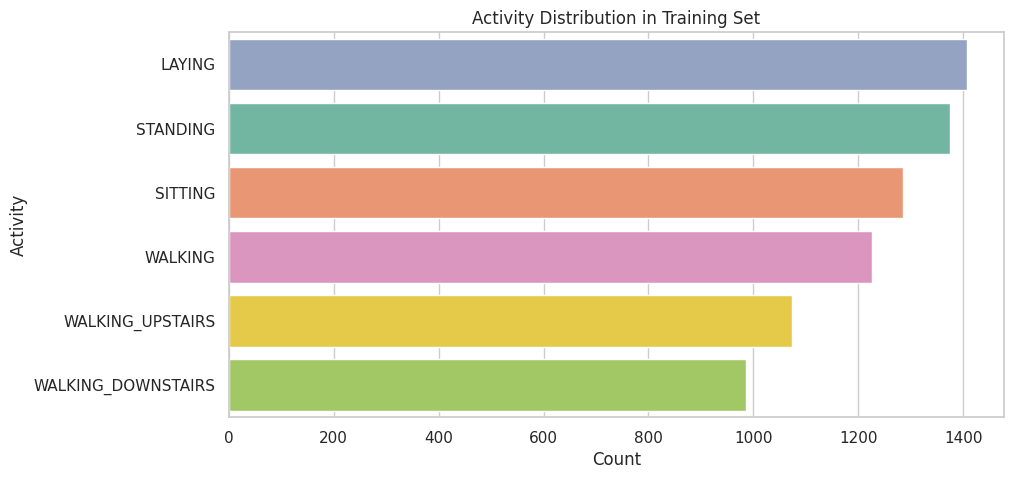

In [11]:
plt.figure(figsize=(10, 5))
sns.countplot(y = y_train, order=y_train.value_counts().index, palette='Set2', hue=y_train, legend=False)
plt.title('Activity Distribution in Training Set')
plt.xlabel('Count')
plt.ylabel('Activity')
plt.show()

<h3 style='color:purple'>Check Subject Distribution</h3>

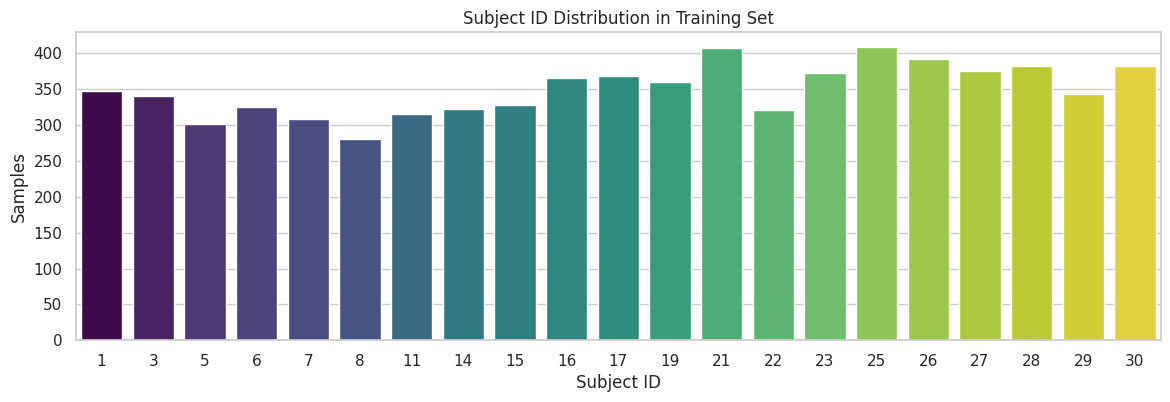

In [12]:
plt.figure(figsize=(14, 4))
sns.countplot(x=subject_train, palette='viridis', hue=subject_train, legend=False)
plt.title('Subject ID Distribution in Training Set')
plt.xlabel('Subject ID')
plt.ylabel('Samples')
plt.show()

<h2 style='color:green'>Exploratory Data Analysis (EDA)</h2>

<h3 style='color:purple'>Class Distribution - Activity Frequency</h3>

In [13]:
activity_counts = y_train.value_counts()
activity_counts

0
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64

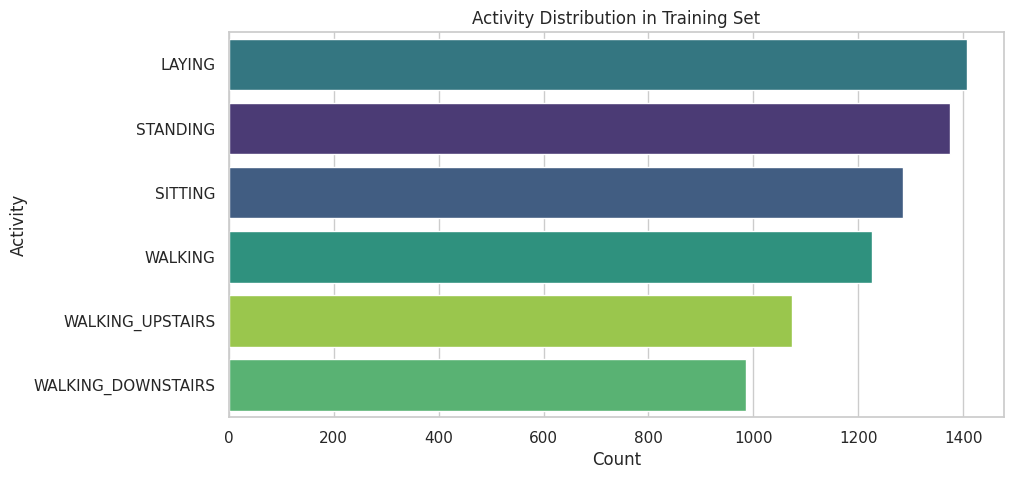

In [14]:
# plot to chech Whether the dataset has a balanced number of samples per activity
# Imbalanced classes can lead to biased models

plt.figure(figsize=(10, 5))
sns.countplot(y=y_train, order=activity_counts.index, palette='viridis', hue=y_train, legend=False)
plt.xlabel('Count')
plt.ylabel('Activity')
plt.title('Activity Distribution in Training Set')
plt.show()

In [15]:
# Display Count & Percentage

activity_percentage = round(activity_counts / len(y_train) * 100, 2)
activity_summary = pd.DataFrame({
    "Activity": activity_counts.index, 
    "Count": activity_counts.values,
    'Percentage': activity_percentage.values
})

activity_summary

Activity  Count  Percentage
0              LAYING   1407       19.14
1            STANDING   1374       18.69
2             SITTING   1286       17.49
3             WALKING   1226       16.68
4    WALKING_UPSTAIRS   1073       14.59
5  WALKING_DOWNSTAIRS    986       13.41

<h3 style='color:purple'>Subject Distribution - Who Contributed How Much?</h3>

In [16]:
subject_count = subject_train.value_counts().sort_index()
subject_count

0
1     347
3     341
5     302
6     325
7     308
8     281
11    316
14    323
15    328
16    366
17    368
19    360
21    408
22    321
23    372
25    409
26    392
27    376
28    382
29    344
30    383
Name: count, dtype: int64

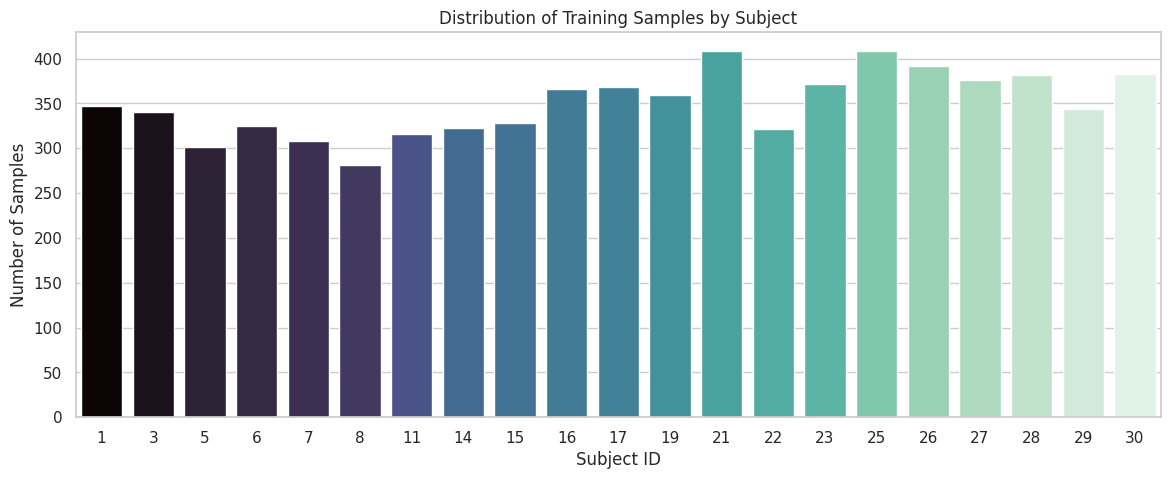

In [17]:
# Plot to see Whether some subjects dominate the training set
# Helps you design subject-aware cross-validation

plt.figure(figsize=(14, 5))
sns.barplot(x=subject_count.index, y=subject_count.values, palette='mako', hue=subject_count.index, legend=False)
plt.title('Distribution of Training Samples by Subject')
plt.xlabel('Subject ID')
plt.ylabel('Number of Samples')
plt.show()

In [18]:
# Display min, max, mean 
print("Min Samples: ", subject_count.min())
print("Max Samples: ", subject_count.max())
print("Mean Samples per subject: ", round(subject_count.mean(), 2))

Min Samples:  281
Max Samples:  409
Mean Samples per subject:  350.1


<h3 style='color:purple'>Feature Correlation - Heatmap for Top N Features</h3>

In [19]:
feature_variances = X_train.var()

In [20]:
# Removing correlated features can reduce overfitting and speed up training

top_n = 50
top_features = feature_variances.sort_values(ascending=False).head(top_n).index
top_features

Index(['fBodyAccJerk-entropy()-X', 'fBodyAccJerk-entropy()-Y',
       'tBodyAccJerkMag-entropy()', 'fBodyAcc-entropy()-X',
       'tGravityAcc-correlation()-X,Z', 'tGravityAcc-correlation()-Y,Z',
       'tBodyGyroJerkMag-entropy()', 'tGravityAcc-energy()-X',
       'tGravityAcc-correlation()-X,Y', 'fBodyAccMag-entropy()',
       'tBodyAccMag-entropy()', 'tGravityAccMag-entropy()',
       'fBodyBodyAccJerkMag-entropy()', 'fBodyAcc-entropy()-Y',
       'tBodyAccJerk-entropy()-X', 'fBodyAccJerk-entropy()-Z',
       'tBodyAccJerk-entropy()-Y', 'fBodyBodyGyroJerkMag-entropy()',
       'fBodyGyro-entropy()-Y', 'fBodyAcc-entropy()-Z',
       'fBodyGyro-entropy()-X', 'tBodyAccJerk-entropy()-Z',
       'fBodyBodyGyroMag-entropy()', 'fBodyGyro-entropy()-Z',
       'angle(tBodyGyroMean,gravityMean)', 'tBodyGyroJerk-entropy()-Z',
       'tBodyGyroJerk-entropy()-X', 'tBodyGyroJerk-entropy()-Y',
       'tBodyAcc-max()-X', 'tGravityAcc-mean()-X', 'angle(X,gravityMean)',
       'tGravityAcc-max()-X', 

In [21]:
corr_matrix = X_train[top_features].corr()

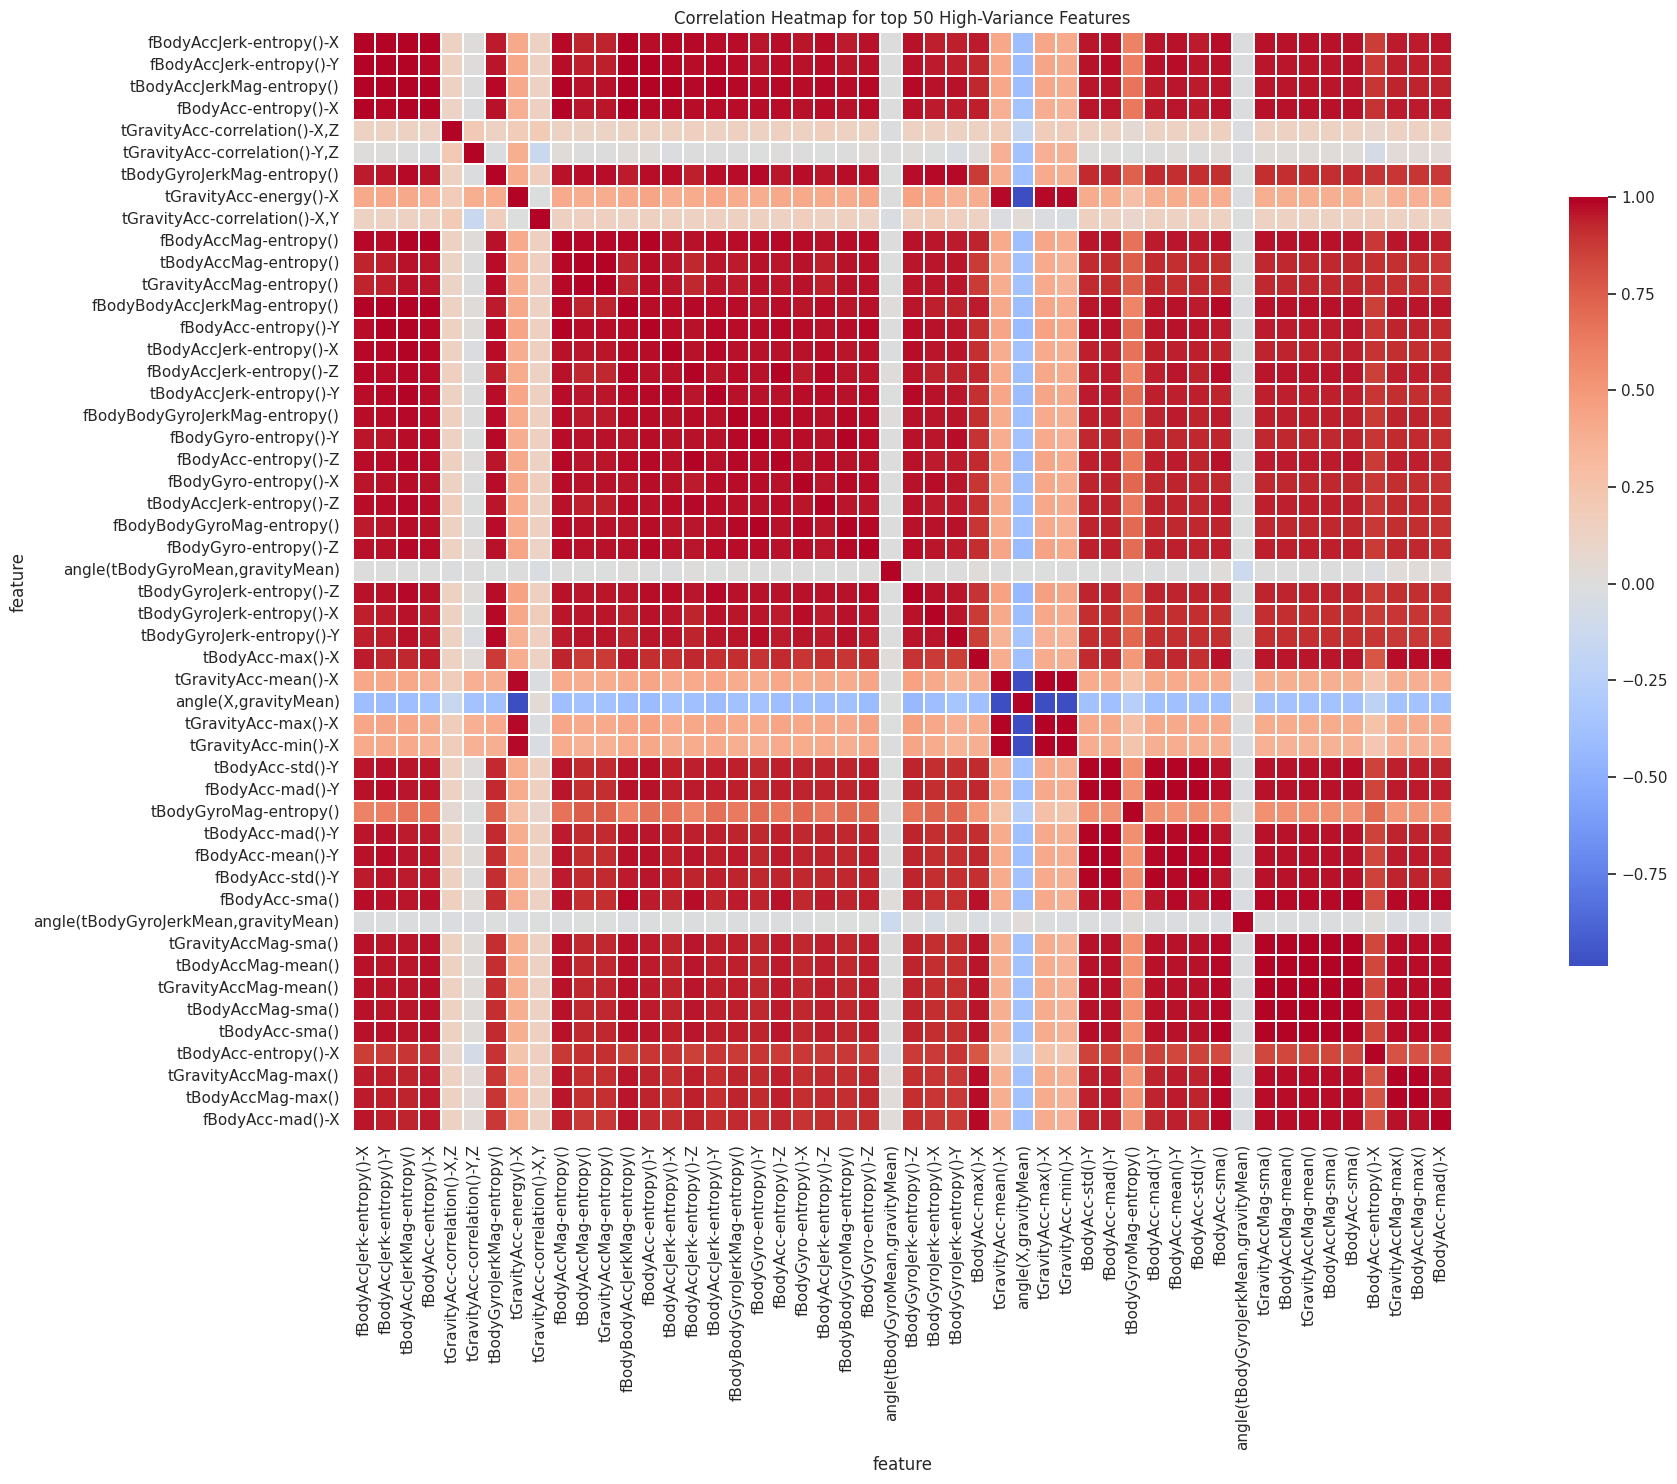

In [22]:
# Plot correlation Heatmap to Visualize feature correlations (redundancy)
# Identify and optionally remove low-variance features (uninformative)

plt.figure(figsize=(24, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, linewidths=0.1, cbar_kws={"shrink": 0.7})
plt.title(f"Correlation Heatmap for top {top_n} High-Variance Features")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<h3 style='color:purple'>Feature Variance - Detect Low Variance Features</h3>

In [23]:
# Features with very low variance (almost constant) â†’ no predictive power
# Dropping them can reduce noise and improve accuracy

variances = X_train.var()

In [24]:
# Define low variance threshold

threshold = 0.01
low_variance_feature = variances[variances < threshold]

In [25]:
# Display result 
print(f"Number of Low Variance Feature (< {threshold}): len{len(low_variance_feature)}")
print("Sample low_variance feature: ")
print(low_variance_feature.head())

Number of Low Variance Feature (< 0.01): len37
Sample low_variance feature: 
feature
tBodyAcc-mean()-X      0.004937
tBodyAcc-mean()-Y      0.001665
tBodyAcc-mean()-Z      0.003208
tGravityAcc-std()-X    0.006084
tGravityAcc-std()-Y    0.008366
dtype: float64


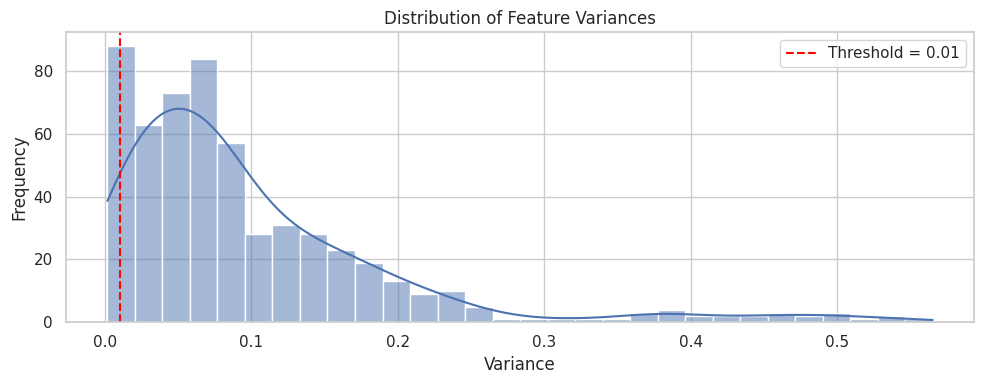

In [26]:
# plot 
plt.figure(figsize=(10, 4))
sns.histplot(variances, bins=30, kde=True) 
plt.axvline(x=threshold, color='red',linestyle='--', label=f"Threshold = {threshold}")
plt.title('Distribution of Feature Variances')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

<h3 style='color:purple'>PCA for Visualization</h3>

In [27]:
# import pca and standard scaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [28]:
# Standarize feature
scalar = StandardScaler()
X_scaled = scalar.fit_transform(X_train)

In [29]:
# PCA to 2D: PCA with two component
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

In [30]:
# create dataframe for plotting
pca_df_2d = pd.DataFrame(data=X_pca_2d, columns=['PC1', 'PC2'])
pca_df_2d['Activity'] = y_train.values

In [31]:
pca_df_2d.head()

PC1       PC2  Activity
0 -16.138544  2.152024  STANDING
1 -15.296194  1.387144  STANDING
2 -15.137019  2.473351  STANDING
3 -15.350884  3.915681  STANDING
4 -15.544814  4.598737  STANDING

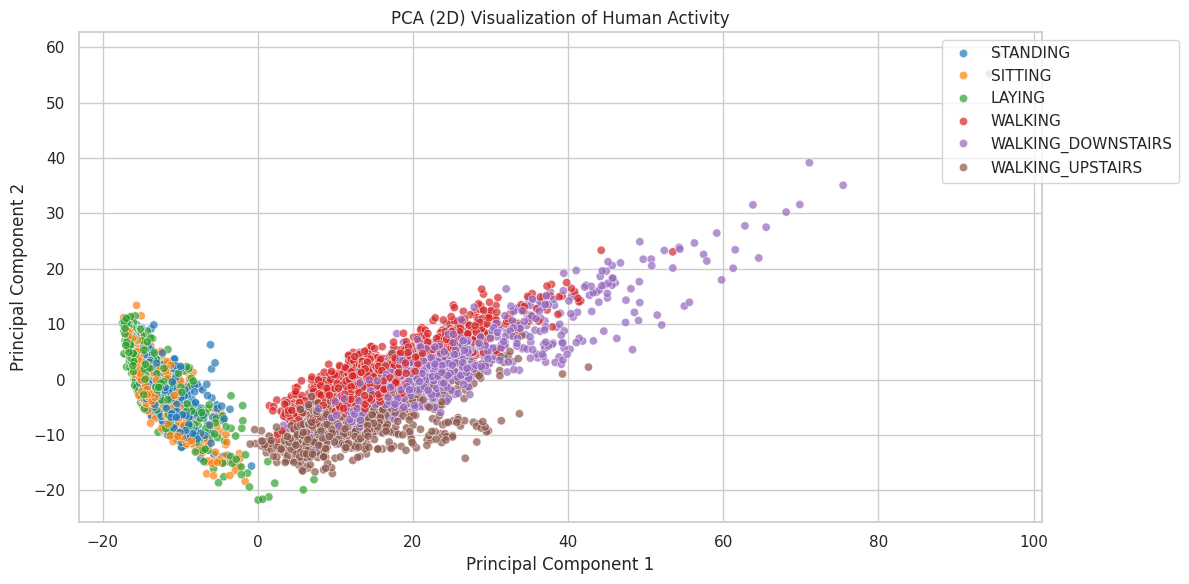

In [32]:
# plot 2D PCA
plt.figure(figsize=(12, 6))
sns.scatterplot(data=pca_df_2d, x='PC1', y='PC2', hue='Activity', palette='tab10', alpha=0.7)
plt.title('PCA (2D) Visualization of Human Activity')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

<h3 style='color:purple'> Optional: PCA to 3D (More Insightful)</h3>

In [33]:
from mpl_toolkits.mplot3d import Axes3D

In [34]:
# PCA with theree components
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

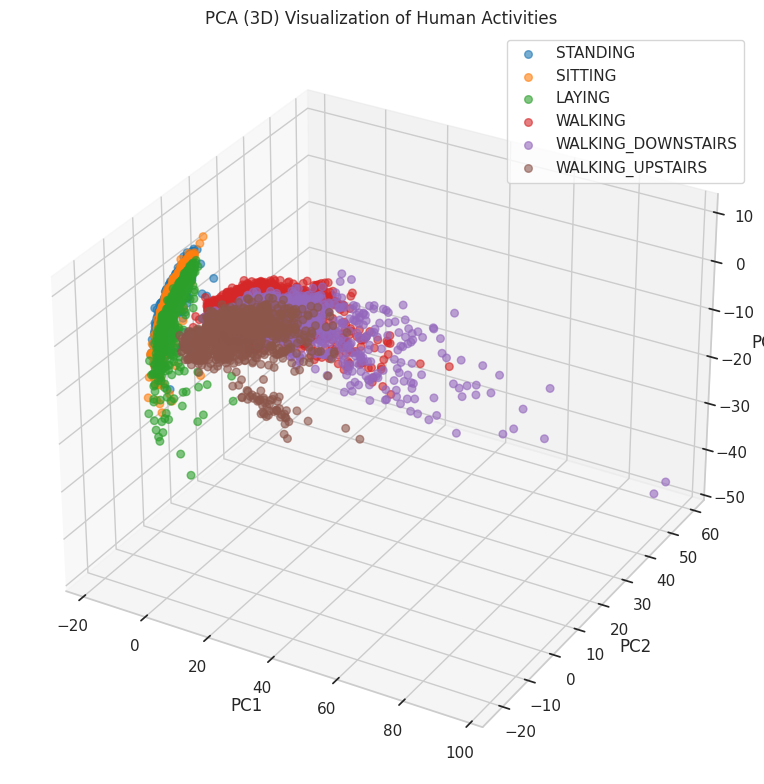

In [35]:
# 3D Plot 
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Map color to Activity 
activities = y_train.unique()
palette = sns.color_palette('tab10', len(activities))
colormap = dict(zip(activities, palette))

for activity in activities: 
    idx = y_train == activity
    ax.scatter(X_pca_3d[idx, 0], X_pca_3d[idx, 1], X_pca_3d[idx, 2],
              label = activity, alpha=0.6, s=30, color=colormap[activity])

ax.set_title("PCA (3D) Visualization of Human Activities")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.tight_layout()
plt.show()

<h2 style='color:green'>Data Preprocessing</h2>

<h3 style='color:purple'>Feature Engineering</h3>

In [36]:
# Group features by type to analyze them (by sensorType)

body_acc_features = [col for col in X_train.columns if 'BodyAcc' in col]
gyro_features = [col for col in X_train.columns if 'Gyro' in col]
freq_features = [col for col in X_train.columns if 'Freq' in col]

print(f"Body Acc Features: {len(body_acc_features)}")
print(f"Gyroscope Features: {len(gyro_features)}")
print(f"Frequency Features: {len(freq_features)} ")

Body Acc Features: 292
Gyroscope Features: 213
Frequency Features: 13 


In [37]:
# Create high level Statistical Summaries

X_train['body_acc_mean'] = X_train[body_acc_features].mean(axis=1)
X_train['body_acc_std'] = X_train[body_acc_features].std(axis=1)

X_test['body_acc_mean'] = X_test[body_acc_features].mean(axis=1)
X_test['body_acc_std'] = X_test[body_acc_features].std(axis=1)

<h3 style='color:purple'>Standardization Using StandardScalar</h3>

In [38]:
# Always fit the scaler on training data only and transform both train and test.(mean 0 & SD 1)
# Prevents data leakage.
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

In [39]:
# Convert to DataFrame 
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [40]:
X_test_scaled.head()

feature  tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
0                -0.246388          -0.136979           1.668462   
1                 0.164235           0.111059          -0.175548   
2                 0.014187          -0.204740          -0.159111   
3                -0.059637          -0.365579          -0.147960   
4                 0.004908          -0.248785          -0.359980   

feature  tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  \
0               -0.742061         -0.814056         -0.150313   
1               -0.824544         -0.908299         -0.812607   
2               -0.865561         -0.913208         -0.855099   
3               -0.867620         -0.919858         -0.865472   
4               -0.865636         -0.908274         -0.892234   

feature  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  tBodyAcc-mad()-Z  \
0               -0.759330         -0.819786         -0.164580   
1               -0.840212         -0.908595         -0.820280   
2               -0.858146         -0.913397         -0.862926   
3               -0.860199         -0.921086         -0.876002   
4               -0.857457         -0.903555         -0.896405   

feature  tBodyAcc-max()-X  ...  fBodyBodyGyroJerkMag-kurtosis()  \
0               -0.781407  ...                        -0.262320   
1               -0.781407  ...                         0.098679   
2               -0.864367  ...                        -0.050207   
3               -0.863173  ...                        -0.360349   
4               -0.863173  ...                        -0.719531   

feature  angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
0                          -0.006596                              0.358560   
1                          -0.273719                              0.034161   
2                          -0.129586                              0.446413   
3                          -0.076465                              0.339639   
4                          -0.032386                             -0.094211   

feature  angle(tBodyGyroMean,gravityMean)  \
0                               -1.372126   
1                               -0.728470   
2                                0.091042   
3                                0.544845   
4                                1.196836   

feature  angle(tBodyGyroJerkMean,gravityMean)  angle(X,gravityMean)  \
0                                    0.579845             -0.450322   
1                                    1.938673             -0.407493   
2                                    0.316041             -0.416639   
3                                    0.632687             -0.409180   
4                                   -0.235517             -0.396070   

feature  angle(Y,gravityMean)  angle(Z,gravityMean)  body_acc_mean  \
0                    0.733571             -0.005244      -0.639029   
1                    0.748840             -0.098112      -0.816610   
2                    0.744605             -0.081803      -0.836101   
3                    0.758155             -0.073784      -0.852731   
4                    0.780371             -0.062135      -0.848469   

feature  body_acc_std  
0           -0.139548  
1           -0.214146  
2            0.165792  
3           -0.079221  
4           -0.453326  

[5 rows x 563 columns]

In [41]:
# Check Scaling Results (mean~0 & SD~1)
print("Mean of Scaled Training Features (approx.): ")
print(np.round(X_train_scaled.mean(), 2).head())

print("\nStd of Scaled Training Features (approx.): ")
print(np.round(X_test_scaled.std(), 2).head())

Mean of Scaled Training Features (approx.): 
feature
tBodyAcc-mean()-X   -0.0
tBodyAcc-mean()-Y    0.0
tBodyAcc-mean()-Z    0.0
tBodyAcc-std()-X    -0.0
tBodyAcc-std()-Y     0.0
dtype: float64

Std of Scaled Training Features (approx.): 
feature
tBodyAcc-mean()-X    0.86
tBodyAcc-mean()-Y    0.63
tBodyAcc-mean()-Z    0.75
tBodyAcc-std()-X     0.92
tBodyAcc-std()-Y     0.98
dtype: float64


<h3 style='color:purple'>Feature Selection</h3>

<h3 style='color:purple'>Using SelectKBest + f_classif</h3>

In [42]:
from sklearn.feature_selection import SelectKBest, f_classif

In [43]:
k = 150  # Top 150 Features
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [44]:
# Get Selected Featres Names
selected_mask = selector.get_support()
selected_features = X_train.columns[selected_mask]

print(f"Top {k} Selected Features:\n ")
print(selected_features.to_list())

Top 150 Selected Features:
 
['tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y', 'tBodyAcc-sma()', 'tBodyAcc-energy()-X', 'tBodyAcc-iqr()-X', 'tBodyAcc-iqr()-Y', 'tBodyAcc-iqr()-Z', 'tGravityAcc-mean()-X', 'tGravityAcc-max()-X', 'tGravityAcc-min()-X', 'tGravityAcc-energy()-X', 'tBodyAccJerk-std()-X', 'tBodyAccJerk-std()-Y', 'tBodyAccJerk-std()-Z', 'tBodyAccJerk-mad()-X', 'tBodyAccJerk-mad()-Y', 'tBodyAccJerk-mad()-Z', 'tBodyAccJerk-max()-X', 'tBodyAccJerk-max()-Y', 'tBodyAccJerk-min()-X', 'tBodyAccJerk-min()-Y', 'tBodyAccJerk-sma()', 'tBodyAccJerk-iqr()-X', 'tBodyAccJerk-iqr()-Y', 'tBodyAccJerk-entropy()-X', 'tBodyAccJerk-entropy()-Y', 'tBodyAccJerk-entropy()-Z', 'tBodyGyro-std()-X', 'tBodyGyro-std()-Z', 'tBodyGyro-mad()-X', 'tBodyGyro-mad()-Z', 'tBodyGyro-sma()', 'tBodyGyro-iqr()-X', 'tBodyGyroJerk-std()-X', 'tBodyGyroJerk-std()-Z', 'tBod

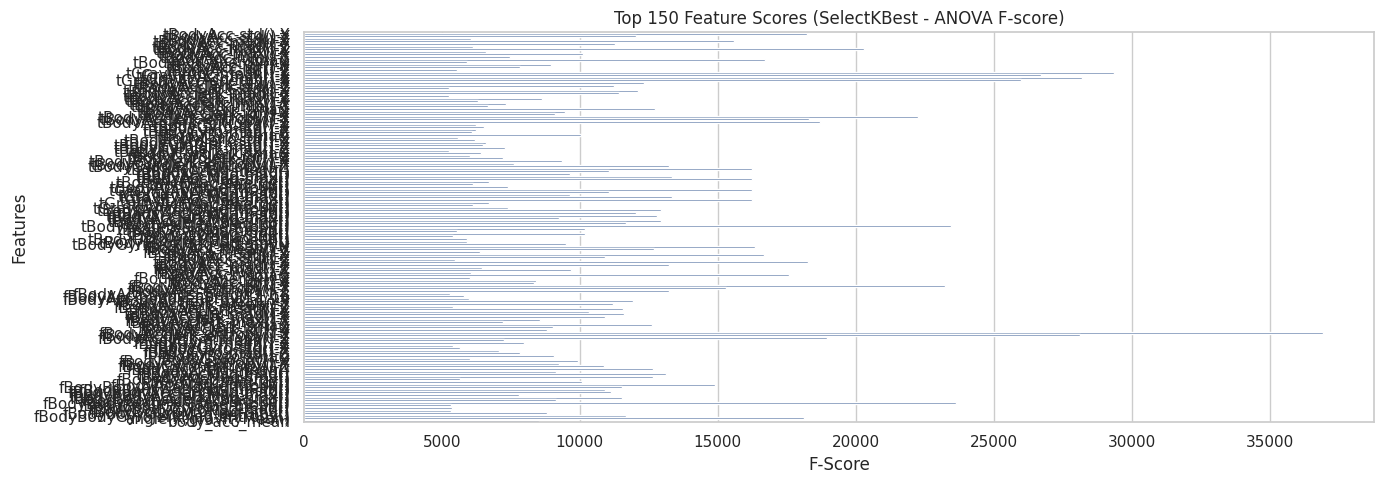

In [45]:
# ðŸ“Š Plot Feature Scores
scores = selector.scores_[selected_mask]

plt.figure(figsize=(14, 5))
sns.barplot(x=scores, y=selected_features)
plt.title(f"Top {k} Feature Scores (SelectKBest - ANOVA F-score)")
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

<h3 style='color:purple'>Using RandomForestClassifier for Feature Importance</h3>

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [48]:
importances = rf.feature_importances_

importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

In [49]:
# select top 150
top_rf_features = importances_df.head(150)['Feature'].values

In [50]:
# Reduce Dataset
X_train_rf_selected = X_train_scaled[top_rf_features]
X_test_rf_selected = X_test_scaled[top_rf_features]

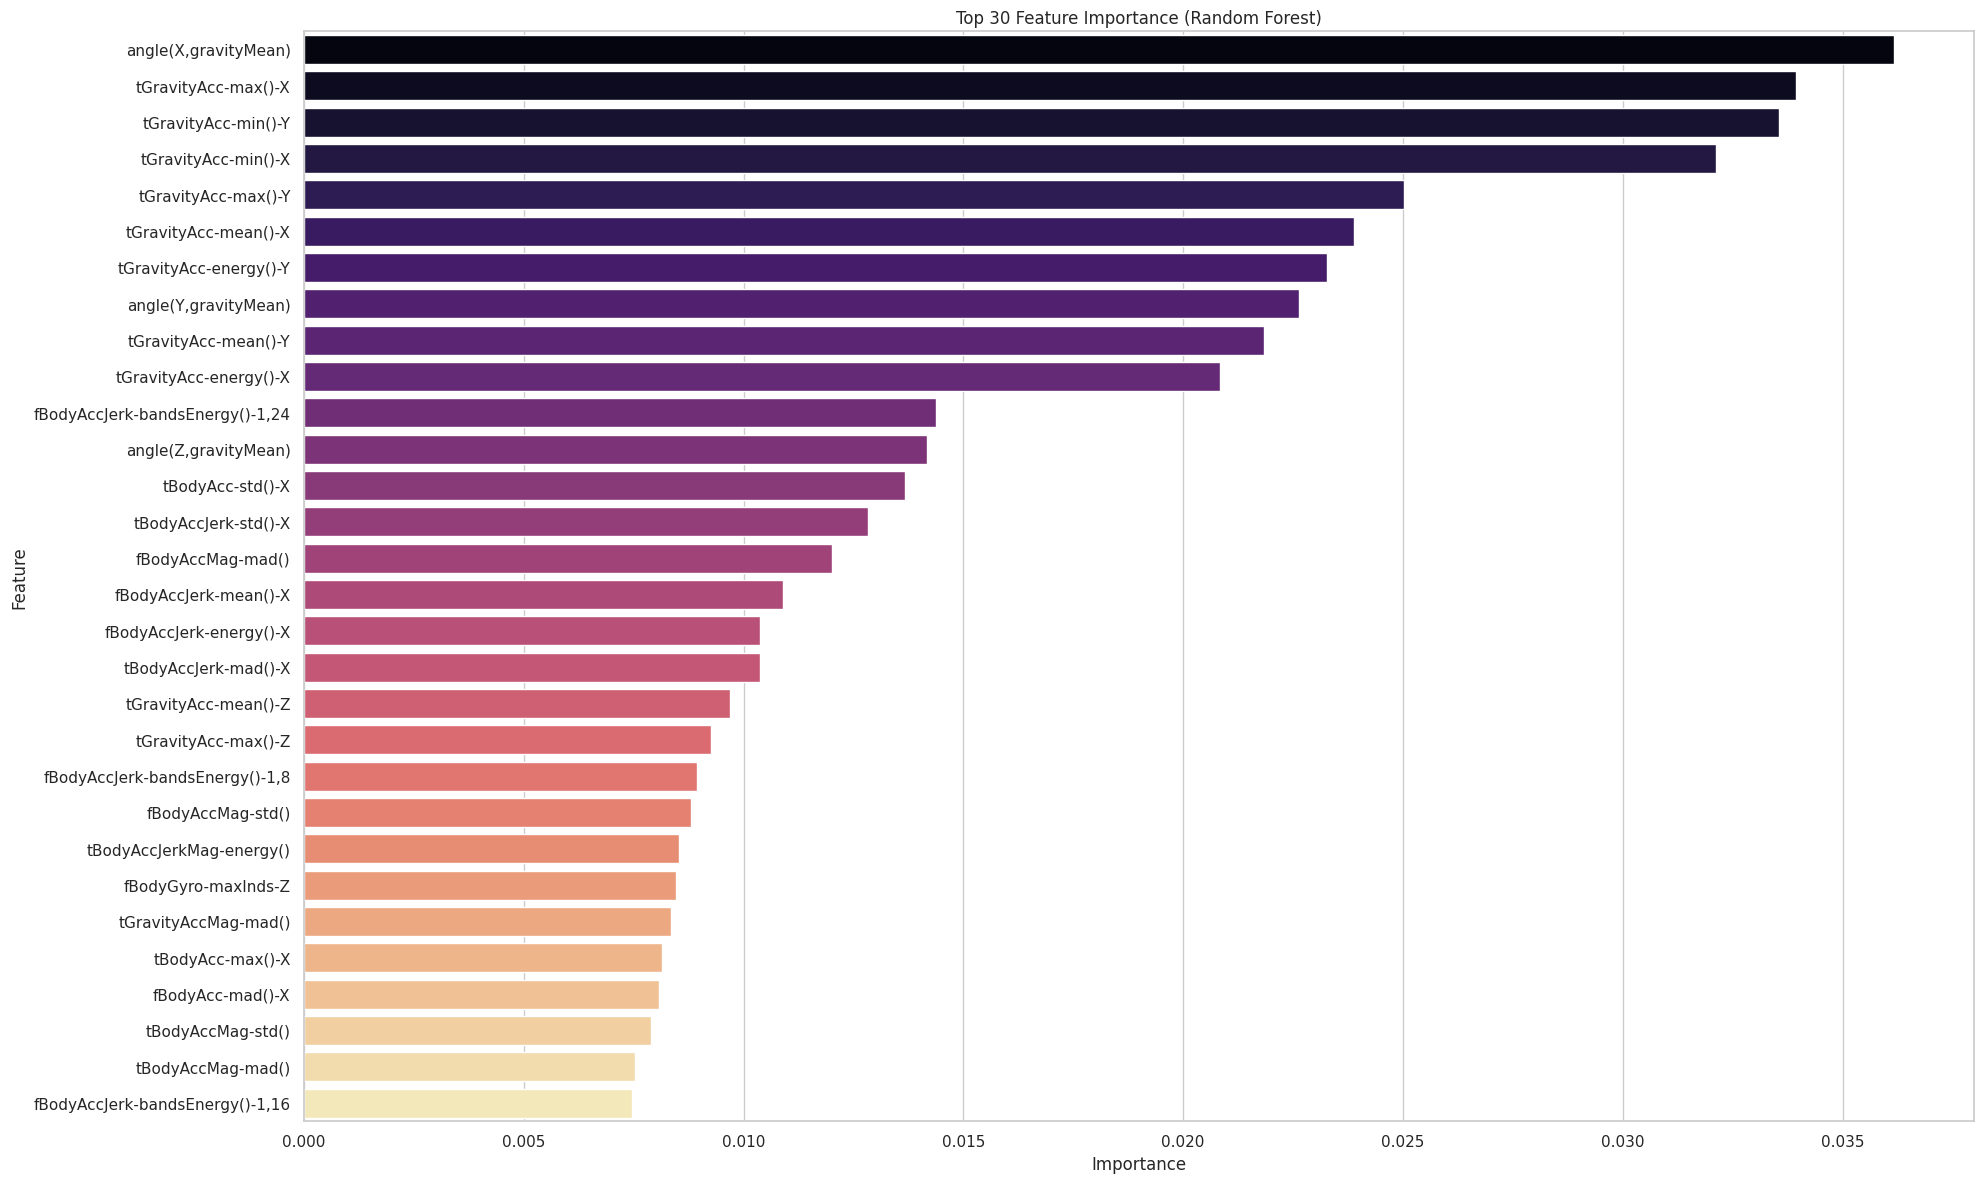

In [51]:
# Plot Top 30 Feature Importances
plt.figure(figsize=(20, 12))

sns.barplot(x='Importance', y='Feature', data=importances_df.head(30), palette='magma', hue='Feature', legend=False)
plt.title('Top 30 Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

<h3 style='color:purple'>Dimensionality Reduction Using PCA</h3>

In [52]:
# Use PCA to reduce feature space
from sklearn.decomposition import PCA

# Apply PCA to Retain 98% of variance
pca = PCA(n_components= 0.9805, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [53]:
print(f"Number of PCA Components Retained: {pca.n_components_} ")

Number of PCA Components Retained: 150 


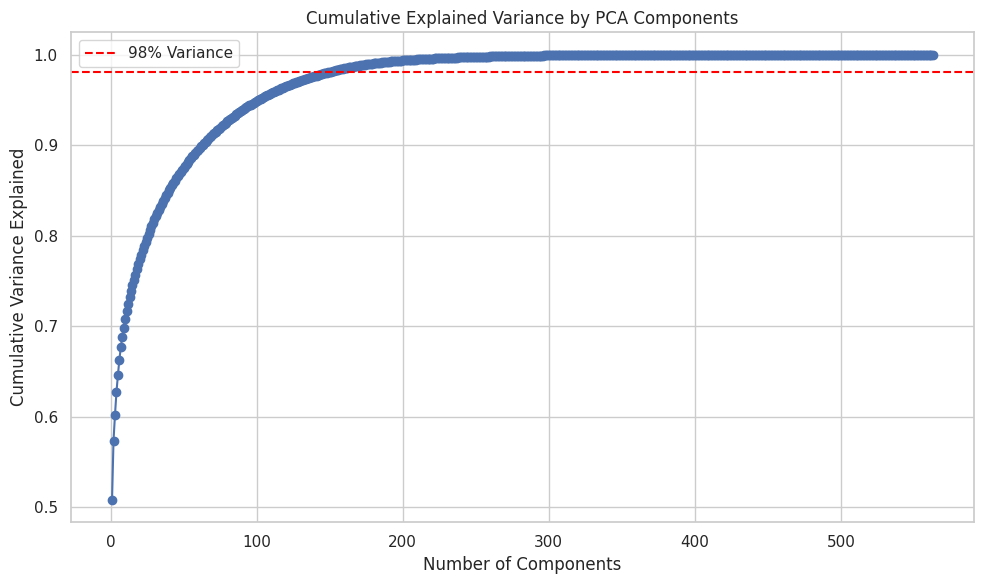

In [54]:
# Plot Cumulative Explained Variance
pca_full = PCA().fit(X_train_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(y=0.9805, color='red', linestyle='--', label='98% Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True) 
plt.tight_layout()
plt.legend()
plt.show()

<h3 style='color:purple'>Feature Comparison â€” Cross-Validation Benchmark</h3> 

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [56]:
# Define cross Validation Function 

def evaluate_model(X, y, name, model=None): 
    if model is None:
        model=RandomForestClassifier(n_estimators=100, random_state=42)

    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{name} Accuracy: {scores.mean():.4f} Â± {scores.std():.4f} ")
    return scores.mean()

In [57]:
# Run Comparision
results = {}

# PCA (X_train_pca)
results['PCA (98%)'] = evaluate_model(X_train_pca, y_train, "PCA (98%)")

# SelectKBest
results['SelectKBest (top 150)'] = evaluate_model(X_train_selected, y_train, "SelectKBest (top 150)")

# RF Top Features
results['RandomForest (top 150)'] = evaluate_model(X_train_rf_selected, y_train, "RandomForest (top 150)")


PCA (98%) Accuracy: 0.8542 Â± 0.0190 
SelectKBest (top 150) Accuracy: 0.9014 Â± 0.0295 
RandomForest (top 150) Accuracy: 0.9147 Â± 0.0178 


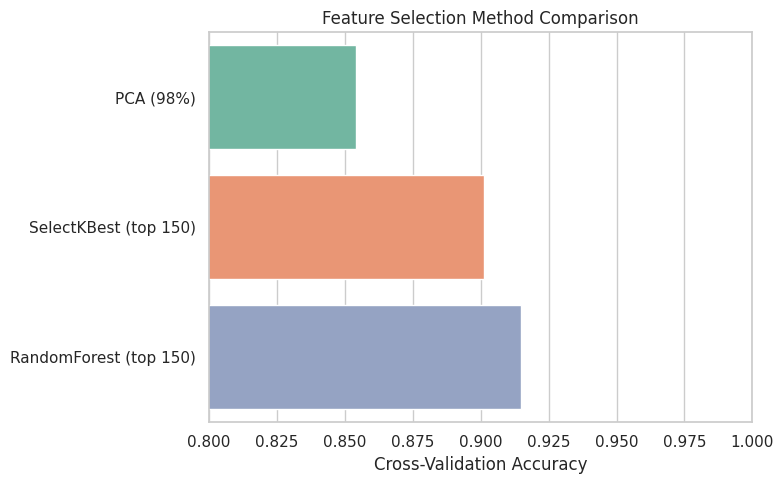

In [58]:
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.values()), y=list(results.keys()), palette="Set2", hue=list(results.keys()), legend=False)
plt.xlabel("Cross-Validation Accuracy")
plt.title("Feature Selection Method Comparison")
plt.xlim(0.8, 1.0)
plt.tight_layout()
plt.show()

<h2 style='color:green'>Model Building</h2>

<h3 style='color:purple'>Random Forest Classifier</h3> 

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
import seaborn as sns 
import matplotlib.pyplot as plt

In [60]:
# Train Model 

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf_selected, y_train)

RandomForestClassifier(random_state=42)

In [61]:
# Check train and test score
rf_model.score(X_train_rf_selected, y_train)*100, rf_model.score(X_test_rf_selected, y_test)*100

(100.0, 92.19545300305396)

In [62]:
# Predict on Test Set
y_pred_rf = rf_model.predict(X_test_rf_selected)

In [63]:
# Model Evaluation: Accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report")
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.9220

Classification Report
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.90      0.86      0.88       491
          STANDING       0.88      0.91      0.89       532
           WALKING       0.90      0.97      0.93       496
WALKING_DOWNSTAIRS       0.96      0.87      0.91       420
  WALKING_UPSTAIRS       0.91      0.90      0.90       471

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



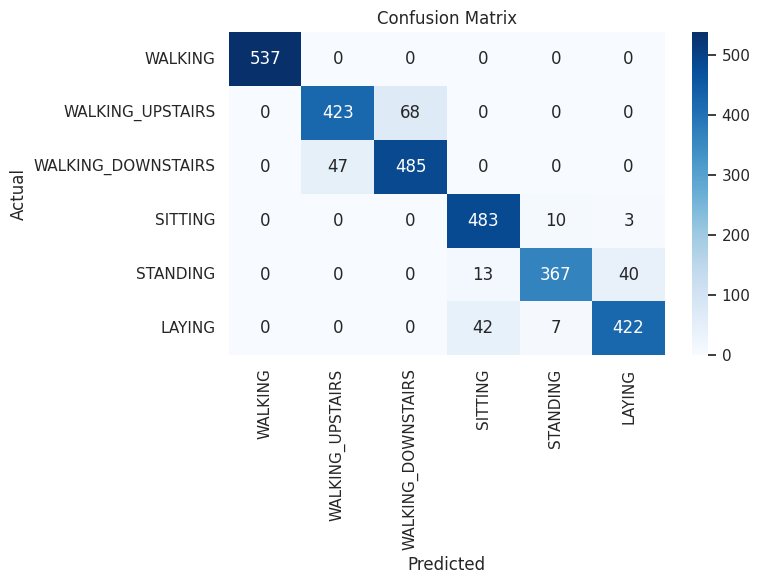

In [64]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=activity_labels.activity.values, 
            yticklabels=activity_labels.activity.values)
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [65]:
# Save the model 
import joblib 
joblib.dump(rf_model, "../models/rf_har_model.pkl")

['../models/rf_har_model.pkl']

<h3 style='color:purple'>Support Vector Machine (SVM)</h3> 

In [66]:
from sklearn.svm import SVC

In [67]:
# Train rbf model
svm = SVC(C=1.0, random_state=42, kernel='rbf', gamma='scale', coef0=0.01)
svm.fit(X_train_scaled, y_train)

SVC(coef0=0.01, random_state=42)

In [68]:
# Check train and test score
svm.score(X_train_scaled, y_train)*100, svm.score(X_test_scaled, y_test)*100

(98.68063112078346, 95.21547336274178)

In [69]:
# Predict on Test Set
y_pred_svm = svm.predict(X_test_scaled)

In [70]:
# Model Evaluation: Accuracy
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report")
print(classification_report(y_test, y_pred_svm))

Accuracy: 0.9522

Classification Report
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.94      0.90      0.92       491
          STANDING       0.92      0.95      0.93       532
           WALKING       0.96      0.97      0.97       496
WALKING_DOWNSTAIRS       0.98      0.92      0.95       420
  WALKING_UPSTAIRS       0.93      0.97      0.95       471

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947



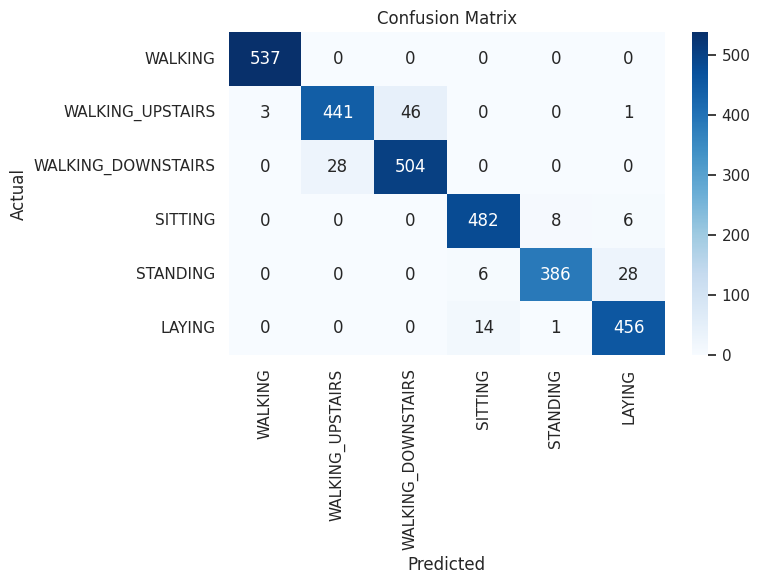

In [71]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=activity_labels.activity.values, 
            yticklabels=activity_labels.activity.values)
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [72]:
# Save Model 

import joblib 
joblib.dump(svm, "../models/svm_har_model.pkl")

['../models/svm_har_model.pkl']

<h3 style='color:purple'>K-Nearest Neighbors (KNN)</h3> 

In [73]:
from sklearn.neighbors import KNeighborsClassifier

In [74]:
# Train KNN Model 
knn = KNeighborsClassifier(n_neighbors=13, weights='distance', n_jobs=-1)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=13, weights='distance')

In [75]:
knn.score(X_train_scaled, y_train), knn.score(X_test_scaled, y_test)

(1.0, 0.8907363420427553)

In [76]:
# Predict on test set
y_pred_knn = knn.predict(X_test_scaled)

In [77]:
# Model Evaluation: Accuracy
accuracy = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report")
print(classification_report(y_test, y_pred_knn))

Accuracy: 0.8907

Classification Report
                    precision    recall  f1-score   support

            LAYING       0.99      0.95      0.97       537
           SITTING       0.91      0.77      0.83       491
          STANDING       0.80      0.95      0.87       532
           WALKING       0.84      0.98      0.91       496
WALKING_DOWNSTAIRS       0.98      0.75      0.85       420
  WALKING_UPSTAIRS       0.88      0.91      0.90       471

          accuracy                           0.89      2947
         macro avg       0.90      0.89      0.89      2947
      weighted avg       0.90      0.89      0.89      2947



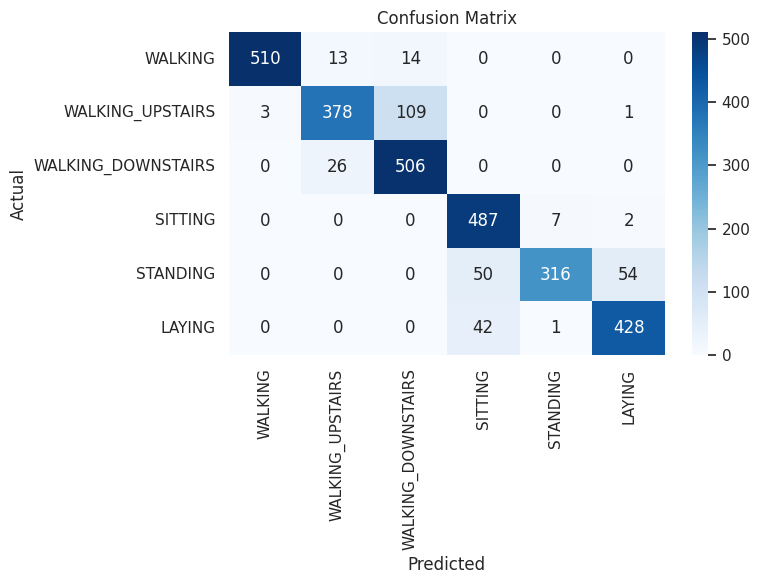

In [78]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=activity_labels.activity.values, 
            yticklabels=activity_labels.activity.values)
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

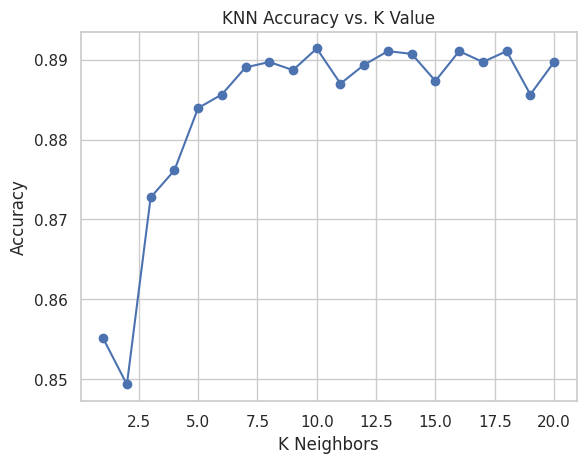

In [79]:
accuracies = []
neighbors = range(1, 21)

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    acc = accuracy_score(y_test, knn.predict(X_test_scaled))
    accuracies.append(acc)

plt.plot(neighbors, accuracies, marker='o')
plt.xlabel("K Neighbors")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs. K Value")
plt.grid(True)
plt.show()


In [80]:
# Save the model 
import joblib 

joblib.dump(knn, "../models/knn_har_model.pkl")

['../models/knn_har_model.pkl']

<h3 style='color:purple'>MLPClassifier (Multi-layer Perceptron)</h3> 

In [81]:
from sklearn.neural_network import MLPClassifier

In [82]:
# Train MPL
mlp = MLPClassifier(hidden_layer_sizes=(200, 100, 50), 
                   activation='relu',
                   solver='adam', 
                   max_iter=400, 
                   alpha=0.001, 
                   random_state=42)

mlp.fit(X_train_scaled, y_train)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(200, 100, 50), max_iter=400,
              random_state=42)

In [83]:
# Training and testing Score
mlp.score(X_train_scaled, y_train)*100, mlp.score(X_test_scaled, y_test)

(100.0, 0.9480827960637936)

In [84]:
# Predict on test set 
y_pred_mlp = mlp.predict(X_test_scaled)

In [85]:
# Model Evaluation: Accuracy
accuracy = accuracy_score(y_test, y_pred_mlp)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report")
print(classification_report(y_test, y_pred_mlp))

Accuracy: 0.9481

Classification Report
                    precision    recall  f1-score   support

            LAYING       1.00      0.97      0.98       537
           SITTING       0.96      0.89      0.92       491
          STANDING       0.88      0.97      0.92       532
           WALKING       0.95      0.99      0.97       496
WALKING_DOWNSTAIRS       0.98      0.91      0.94       420
  WALKING_UPSTAIRS       0.94      0.96      0.95       471

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947



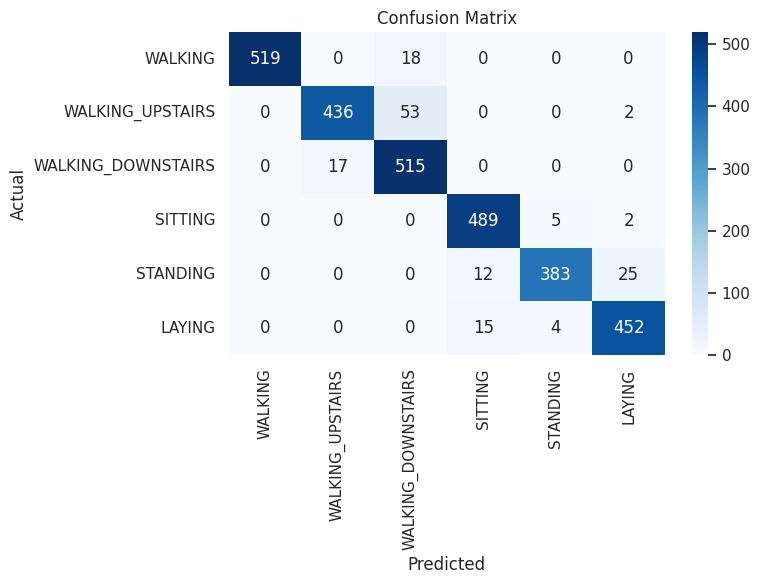

In [86]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_mlp)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=activity_labels.activity.values, 
            yticklabels=activity_labels.activity.values)
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [87]:
# Save the model 
import joblib 

joblib.dump(mlp, "../models/mlp_har_model.pkl")

['../models/mlp_har_model.pkl']

<h3 style='color:purple'>Model Comparision Leaderboard</h3> 

In [88]:
model_scores = {
    'Random Forest':      accuracy_score(y_test, y_pred_rf),
    'SVM (RBF Kernel)':   accuracy_score(y_test, y_pred_svm),
    'KNN (k=5)':          accuracy_score(y_test, y_pred_knn),
    'MLP (200,100,50)':   accuracy_score(y_test, y_pred_mlp),
}

In [89]:
# sort Scores 
sorted_scores = dict(sorted(model_scores.items(), key=lambda item: item[1], reverse=True))

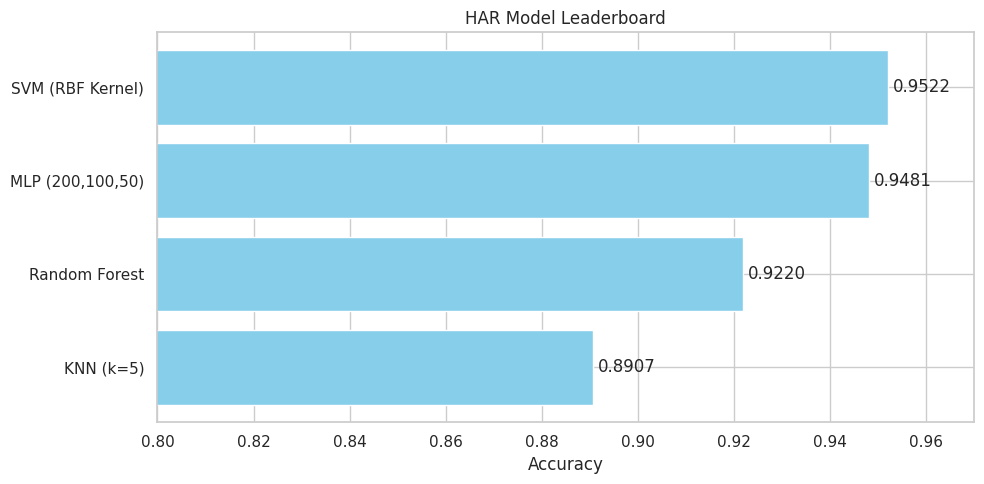

In [90]:
# Barplot
plt.figure(figsize=(10, 5))

plt.barh(list(sorted_scores.keys()), list(sorted_scores.values()), color='skyblue')
plt.xlabel("Accuracy")
plt.title("HAR Model Leaderboard")
plt.gca().invert_yaxis()
for i, (model, score) in enumerate(sorted_scores.items()):
    plt.text(score + 0.001, i, f"{score:.4f}", va='center')
    
plt.xlim(0.80, 0.97)
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

<h2 style='color:green'>Model Tuning for High Accuracy: RandomizedSearchCV</h2>

<h3 style='color:purple'>RandomizedSearchCV for MLP</h3> 

In [91]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [92]:
param_dist = {
    'hidden_layer_sizes': [(100,), (200, 100), (300, 200, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [300, 500]
}

In [93]:
mlp = MLPClassifier(solver='adam', random_state=42)

In [94]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [97]:
random_search_mlp = RandomizedSearchCV(
    estimator=mlp,
    param_distributions= param_dist, 
    n_iter=30, 
    cv=cv, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=2, 
    random_state=42
)

In [98]:
random_search_mlp.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=MLPClassifier(random_state=42), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'alpha': [0.0001, 0.001, 0.01],
                                        'hidden_layer_sizes': [(100,),
                                                               (200, 100),
                                                               (300, 200, 100)],
                                        'learning_rate_init': [0.001, 0.01],
                                        'max_iter': [300, 500]},
                   random_state=42, scoring='accuracy', verbose=2)

<h3 style='color:purple'>View Best Parameters and Evaluate (MLP)</h3> 

In [100]:
print("Best Parameters: ")
print(random_search_mlp.best_params_)

Best Parameters: 
{'max_iter': 500, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'tanh'}
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate_init=0.001, max_iter=300; total time= 2.1min
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=300; total time=  39.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=300; total time=  36.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200, 100), learning_rate_init=0.01, max_iter=300; total time= 1.2min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=300; total time= 1.4min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=300; total time= 1.5min
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200, 100), learning_rate_init=0.001, max_iter=300; to

In [101]:
# Evaluate best model in test set
best_mlp = random_search_mlp.best_estimator_
y_pred_best_mlp = best_mlp.predict(X_test_scaled)

In [102]:
# Model Evaluation: Accuracy
accuracy = accuracy_score(y_test, y_pred_best_mlp)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report")
print(classification_report(y_test, y_pred_best_mlp))

Accuracy: 0.9457

Classification Report
                    precision    recall  f1-score   support

            LAYING       1.00      0.96      0.98       537
           SITTING       0.95      0.89      0.92       491
          STANDING       0.87      0.96      0.91       532
           WALKING       0.95      0.99      0.97       496
WALKING_DOWNSTAIRS       0.98      0.92      0.95       420
  WALKING_UPSTAIRS       0.94      0.96      0.95       471

          accuracy                           0.95      2947
         macro avg       0.95      0.94      0.95      2947
      weighted avg       0.95      0.95      0.95      2947



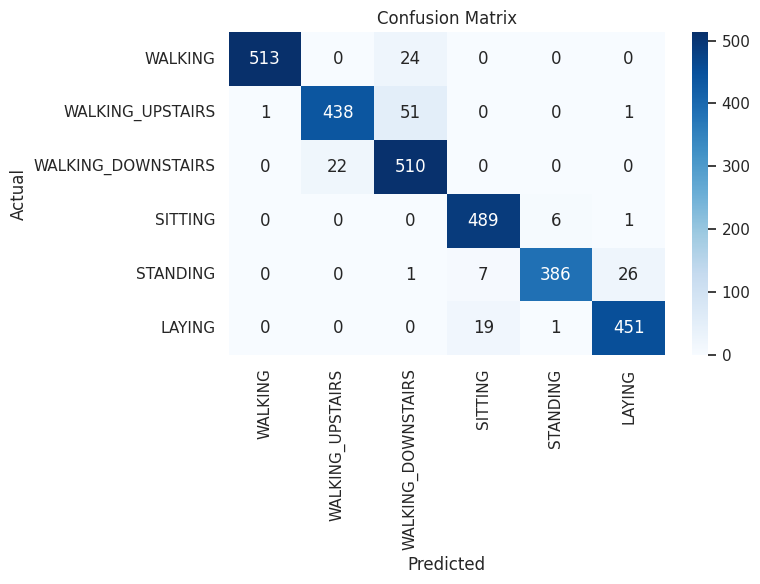

In [103]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best_mlp)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=activity_labels.activity.values, 
            yticklabels=activity_labels.activity.values)
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [104]:
# Save the model 
import joblib 

joblib.dump(best_mlp, "../models/best_mlp_har_model.pkl")

['../models/best_mlp_har_model.pkl']

<h3 style='color:purple'>RandomizedSearchCV for RandomForest</h3> 

In [105]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [106]:
# Define base model
rf = RandomForestClassifier(random_state=42)

In [107]:
# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [108]:
#  Randomized Search
random_search_rf = RandomizedSearchCV(estimator=rf,
                                      param_distributions=param_dist,
                                      n_iter=25, 
                                      cv=cv,
                                      scoring='accuracy',
                                      n_jobs=-1,
                                      verbose=2,
                                      random_state=42)

In [109]:
random_search_rf.fit(X_train_scaled, y_train)

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate_init=0.001, max_iter=300; total time= 2.1min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(200, 100), learning_rate_init=0.001, max_iter=300; total time= 1.5min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(200, 100), learning_rate_init=0.01, max_iter=300; total time= 1.4min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=300; total time= 1.6min
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(200, 100), learning_rate_init=0.001, max_iter=300; total time= 2.0min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=300; total time=  49.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=300; total time=  31.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(300, 200, 100), learning_rate_init=0.01, max_iter=

/home/sabin/myenv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='accuracy', verbose=2)

<h3 style='color:purple'>Evaluate the best RF Model</h3> 

In [110]:
print("Best Parameters: ")
print(random_search_rf.best_params_)

Best Parameters: 
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


In [111]:
# Evaluate best model in test set
best_rf = random_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_scaled)

In [112]:
# Model Evaluation: Accuracy
accuracy = accuracy_score(y_test, y_pred_best_rf)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report")
print(classification_report(y_test, y_pred_best_rf))

Accuracy: 0.9372

Classification Report
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.98      0.88      0.93       491
          STANDING       0.90      0.98      0.94       532
           WALKING       0.91      0.97      0.94       496
WALKING_DOWNSTAIRS       0.95      0.84      0.89       420
  WALKING_UPSTAIRS       0.90      0.93      0.91       471

          accuracy                           0.94      2947
         macro avg       0.94      0.93      0.93      2947
      weighted avg       0.94      0.94      0.94      2947



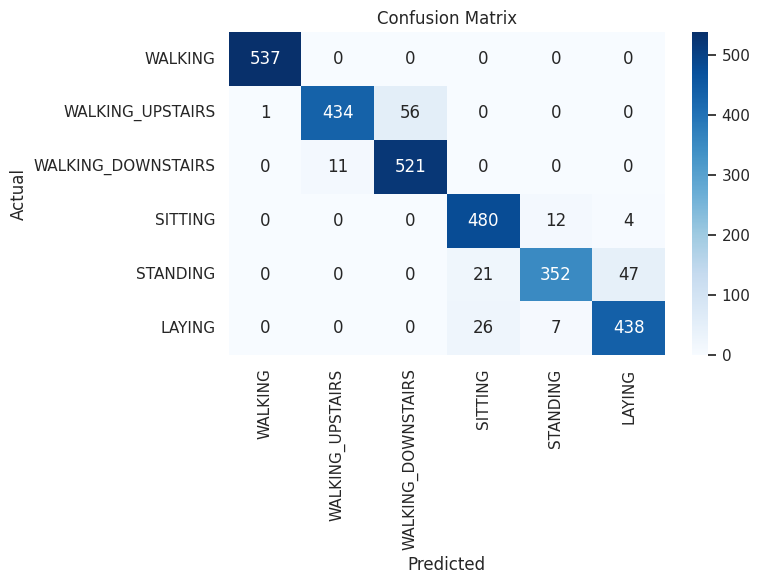

In [113]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best_rf)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=activity_labels.activity.values, 
            yticklabels=activity_labels.activity.values)
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [114]:
# Save the model 
import joblib 

joblib.dump(best_rf, "../models/best_rf_har_model.pkl")

['../models/best_rf_har_model.pkl']

<h3 style='color:purple'>RandomizedSearchCV for SVM</h3> 

In [115]:
param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear'] 
}

In [133]:
# SVM model
svm = SVC(probability=True, random_state=42)

In [134]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [135]:
# Randomized Search
random_search_svm = RandomizedSearchCV(estimator=svm,
                                       param_distributions=param_dist,
                                       n_iter=10,  # 10â€“20 recommended
                                       scoring='accuracy',
                                       cv=cv,
                                       verbose=2,
                                       n_jobs=-1,
                                       random_state=42)

In [136]:
# Fit on scaled features
random_search_svm.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=SVC(probability=True, random_state=42), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': [0.001, 0.01, 0.1, 1],
                                        'kernel': ['rbf', 'linear']},
                   random_state=42, scoring='accuracy', verbose=2)

<h3 style='color:purple'>Evaluate the best SVM Model</h3> 

In [137]:
print("Best Parameters: ")
print(random_search_svm.best_params_)

Best Parameters: 
{'kernel': 'rbf', 'gamma': 0.001, 'C': 100}


In [138]:
# Evaluate best model in test set
best_svm = random_search_svm.best_estimator_
y_pred_best_svm = best_svm.predict(X_test_scaled)

[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=  49.2s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=  58.2s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=  55.8s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time= 1.6min
[CV] END ...................C=10, gamma=0.001, kernel=linear; total time= 1.0min
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time= 2.2min
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time= 2.2min
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=17.7min
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=  57.7s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time= 1.0min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=19.1min
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time= 4.1min
[CV] END ...................

In [139]:
# Model Evaluation: Accuracy
accuracy = accuracy_score(y_test, y_pred_best_svm)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report")
print(classification_report(y_test, y_pred_best_svm))

Accuracy: 0.9589

Classification Report
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.97      0.89      0.93       491
          STANDING       0.92      0.98      0.95       532
           WALKING       0.96      0.98      0.97       496
WALKING_DOWNSTAIRS       0.98      0.93      0.96       420
  WALKING_UPSTAIRS       0.94      0.96      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



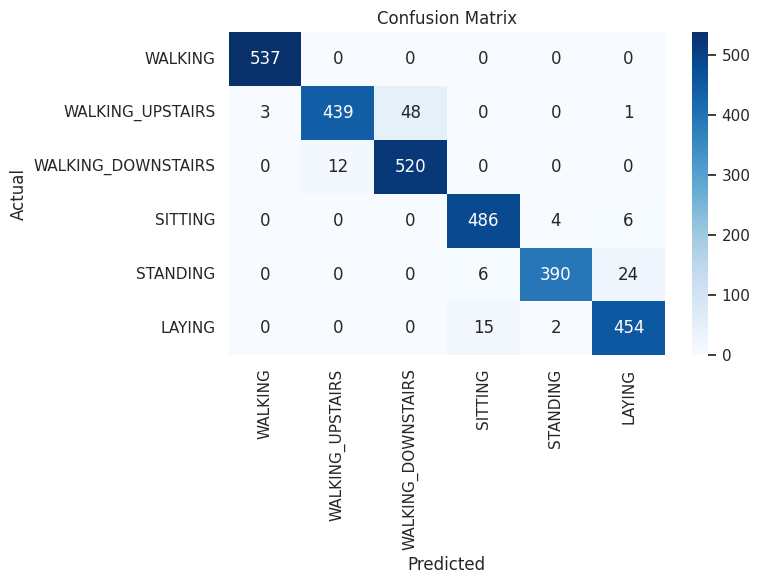

In [140]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best_svm)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=activity_labels.activity.values, 
            yticklabels=activity_labels.activity.values)
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [141]:
# Save the model 
import joblib 

joblib.dump(best_svm, "../models/best_svm_har_model.pkl")

['../models/best_svm_har_model.pkl']

<h2 style='color:green'>Model Optimization</h2>

<h3 style='color:purple'>Ensemble Learning Using VotingCalssifier</h3> 

In [142]:
from sklearn.ensemble import VotingClassifier

In [143]:
import joblib

# Load previously saved models
rf = joblib.load('../models/best_rf_har_model.pkl')
svm = joblib.load('../models/best_svm_har_model.pkl')
mlp = joblib.load('../models/best_mlp_har_model.pkl')

In [144]:
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('svm', svm),
        ('mlp', mlp)
    ],
    voting='soft',   # Soft voting uses predicted probabilities
    n_jobs=-1
)

# Fit ensemble model
ensemble.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_features='log2',
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('svm',
                              SVC(C=100, gamma=0.001, probability=True,
                                  random_state=42)),
                             ('mlp',
                              MLPClassifier(activation='tanh', alpha=0.001,
                                            max_iter=500, random_state=42))],
                 n_jobs=-1, voting='soft')

In [145]:
y_pred_ensemble = ensemble.predict(X_test_scaled)

In [146]:
# Model Evaluation: Accuracy
accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report")
print(classification_report(y_test, y_pred_ensemble))

Accuracy: 0.9593

Classification Report
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.89      0.93       491
          STANDING       0.91      0.97      0.94       532
           WALKING       0.96      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.92      0.96       420
  WALKING_UPSTAIRS       0.94      0.97      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



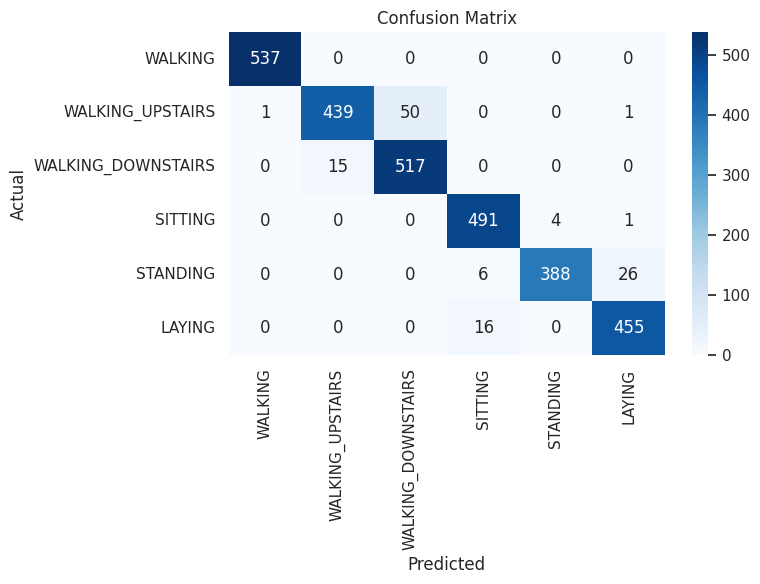

In [147]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ensemble)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=activity_labels.activity.values, 
            yticklabels=activity_labels.activity.values)
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [148]:
#  Save the model 
joblib.dump(ensemble, "../models/ensemble_VC_har_model.pkl")

['../models/ensemble_VC_har_model.pkl']

<h3 style='color:purple'>Stacking with StackingClassifier</h3> 

In [149]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [150]:
# Define meta-learner
meta_model = LogisticRegression(max_iter=1000, random_state=42)

# Create stacking ensemble
stacked_model = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('svm', svm),
        ('mlp', mlp)
    ],
    final_estimator=meta_model,
    cv=5,              # Internal CV to train base learners
    n_jobs=-1,
    passthrough=False  # Only pass meta-model the base predictions
)


In [151]:
stacked_model.fit(X_train_scaled, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_features='log2',
                                                       n_estimators=300,
                                                       random_state=42)),
                               ('svm',
                                SVC(C=100, gamma=0.001, probability=True,
                                    random_state=42)),
                               ('mlp',
                                MLPClassifier(activation='tanh', alpha=0.001,
                                              max_iter=500, random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42),
                   n_jobs=-1)

In [152]:
y_pred_stack = stacked_model.predict(X_test_scaled)

[CV] END ....................C=100, gamma=0.1, kernel=linear; total time= 1.1min
[CV] END ........................C=1, gamma=1, kernel=linear; total time=  55.6s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time= 1.6min
[CV] END ...................C=10, gamma=0.001, kernel=linear; total time=  54.8s
[CV] END ...................C=10, gamma=0.001, kernel=linear; total time= 1.0min
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time= 2.3min
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=  58.5s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=  57.6s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=17.6min
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=  55.3s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=19.7min
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time= 4.1min
[CV] END ...................

In [153]:
# Model Evaluation: Accuracy
accuracy = accuracy_score(y_test, y_pred_stack)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report")
print(classification_report(y_test, y_pred_stack))

Accuracy: 0.9589

Classification Report
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.93      0.95       491
          STANDING       0.94      0.98      0.96       532
           WALKING       0.92      0.99      0.95       496
WALKING_DOWNSTAIRS       0.99      0.91      0.95       420
  WALKING_UPSTAIRS       0.94      0.93      0.93       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



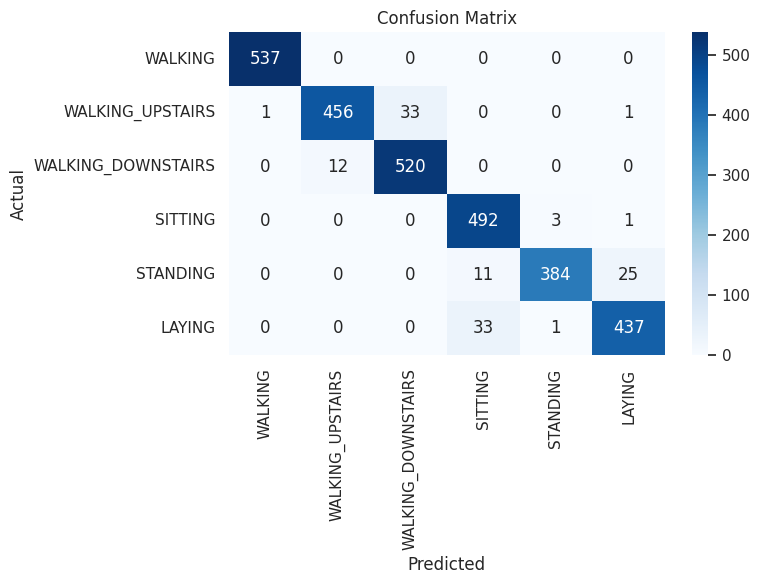

In [154]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_stack)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=activity_labels.activity.values, 
            yticklabels=activity_labels.activity.values)
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [155]:
#  Save the model 
joblib.dump(stacked_model, "../models/stacked_model_har_model.pkl")

['../models/stacked_model_har_model.pkl']

In [164]:
#Save the Scalar 
joblib.dump(scalar, "../models/scalar.pkl")
joblib.dump(selected_features, "../selected_features.pkl")
joblib.dump(selector, "../feature_selector.pkl")

['../feature_selector.pkl']

<h3 style='color:purple'>Identify Most Confused Classes</h3> 

In [156]:
# Confusion matrix as DataFrame
conf_df = pd.DataFrame(cm, index=activity_labels['activity'], columns=activity_labels['activity'])

# Zero out diagonal
np.fill_diagonal(cm, 0)

# Most confused pair (excluding correct predictions)
confused_pair = np.unravel_index(np.argmax(cm), cm.shape)
confused_activities = (activity_labels['activity'][confused_pair[0]],
                       activity_labels['activity'][confused_pair[1]])

print(f"Most Confused Pair: {confused_activities[0]} â†” {confused_activities[1]}")
print(f"Count: {cm[confused_pair]}")


Most Confused Pair: WALKING_UPSTAIRS â†” WALKING_DOWNSTAIRS
Count: 33


<h3 style='color:purple'>Analyze Misclassified Samples</h3> 

In [157]:
# Filter misclassified instances
misclassified = X_test_scaled[y_test != y_pred_stack]
misclassified_true = y_test[y_test != y_pred_stack]
misclassified_pred = pd.Series(y_pred_stack[y_test != y_pred_stack], index=misclassified_true.index)

# Combine for inspection
error_df = pd.DataFrame({
    'True_Label': misclassified_true,
    'Predicted_Label': misclassified_pred
})

# Show top confusion samples
error_df.value_counts().sort_values(ascending=False).head(10)


True_Label          Predicted_Label   
SITTING             STANDING              33
WALKING_UPSTAIRS    WALKING               33
WALKING_DOWNSTAIRS  WALKING_UPSTAIRS      25
STANDING            SITTING               12
WALKING_DOWNSTAIRS  WALKING               11
WALKING             WALKING_DOWNSTAIRS     3
SITTING             LAYING                 1
                    WALKING_UPSTAIRS       1
WALKING             WALKING_UPSTAIRS       1
WALKING_UPSTAIRS    WALKING_DOWNSTAIRS     1
Name: count, dtype: int64